## Imports

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import re
from PyBNG import PyBNG
import shapely
from os import makedirs, path, listdir, remove
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import requests
import zipfile as zpf
from tqdm import tqdm
from PIL import Image
from ADMS_functions import PG_index, PointXYZ_to_latlon, plot_on_map, plot_in_grid_box, process_PG_dataset

/home/users/mwlw3/miniconda3/envs/AQmort/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


## netCDF files: Processing & exploration

In [2]:
run = "014"
folder = f"/home/users/mwlw3/ADMS-Urban/2018_P-G_classes/all_regions/{run}/"
files = [path.join(folder, file) for file in listdir(folder) if path.splitext(file)[-1]==".nc"]

### Space

In [ ]:
shapefilepath = path.join(tmp_folder, "statistical-gis-boundaries-london", "ESRI",
                         "London_Borough_Excluding_MHW.shp")
london_boroughs_gdf = gpd.read_file(shapefilepath).to_crs(epsg=4326)

CRSError: Invalid projection: epsg:4326: (Internal Proj Error: proj_create: no database context specified)

### New Dataset

We can make a new Dataset containing all of the pollutant concentrations, as well as meteorological variables:

In [3]:
files[:5]

['/home/users/mwlw3/ADMS-Urban/2018_P-G_classes/all_regions/014/014.00001.nc',
 '/home/users/mwlw3/ADMS-Urban/2018_P-G_classes/all_regions/014/014.00002.nc',
 '/home/users/mwlw3/ADMS-Urban/2018_P-G_classes/all_regions/014/014.00003.nc',
 '/home/users/mwlw3/ADMS-Urban/2018_P-G_classes/all_regions/014/014.00004.nc',
 '/home/users/mwlw3/ADMS-Urban/2018_P-G_classes/all_regions/014/014.00005.nc']

We concatentate the xarray datasets along the `space` dimension:

In [10]:
progress_bar = tqdm(range(0, len(files)))

new_ds = xr.concat([process_PG_dataset(xr.open_dataset(files[i])) for i in progress_bar], "space")

100%|██████████| 359/359 [09:14<00:00,  1.55s/it]


In [11]:
# Save this for reloading later
new_ds.to_netcdf(path.join(folder, "raw_processed_coordinates.nc"))

In [4]:
# Reload dataset
new_ds = xr.open_dataset(path.join(folder, "raw_processed_coordinates.nc"))

#### Plotting concentration data

Now we can make a Geopandas Dataframe for plotting:

In [30]:
choose_PG_class = "G"
data_column = f"Class_{choose_PG_class}_NO2"

In [31]:
new_gdf = gpd.GeoDataFrame(new_ds.NO2[PG_index.index(choose_PG_class),:].values, 
                 columns=[data_column], 
                 geometry=gpd.points_from_xy(new_ds.longitude.values, new_ds.latitude.values))

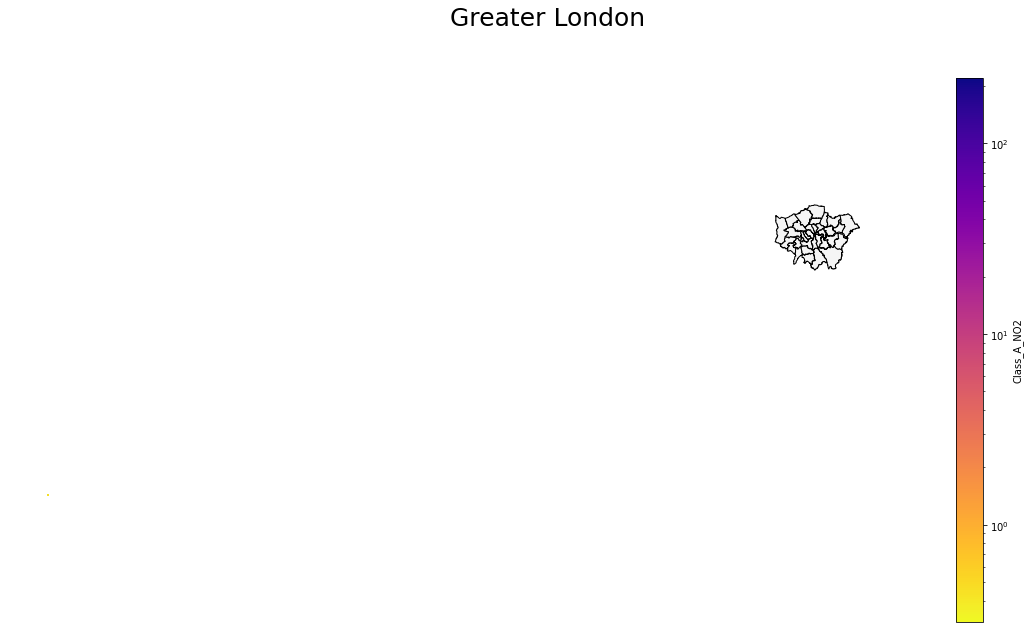

In [86]:
plot_on_map(new_gdf, london_boroughs_gdf, column=data_column, 
            data_cmap="plasma_r", colorbar=True, set_colorbar_log=True)

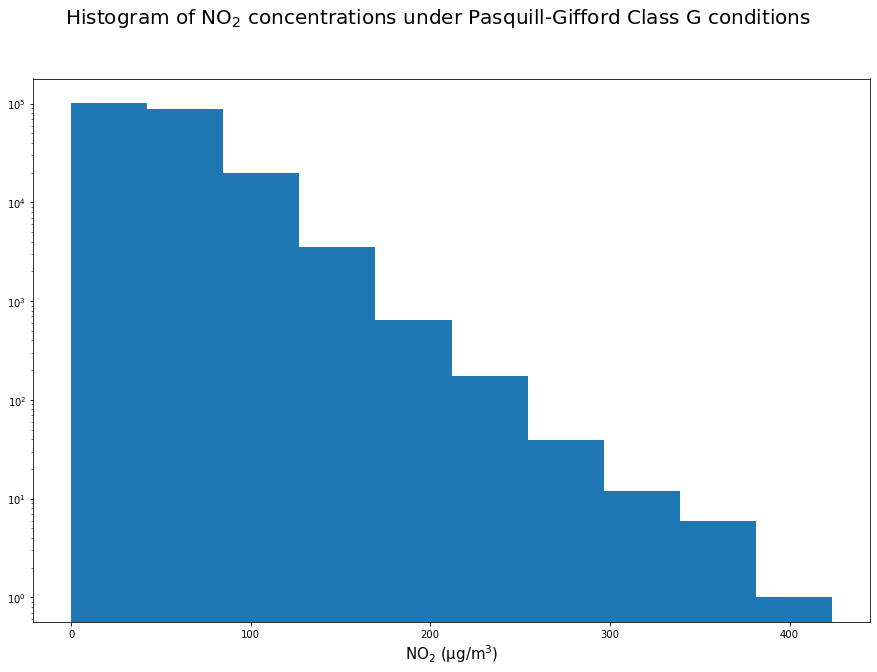

In [32]:
plt.figure(figsize=(15,10))
plt.hist(new_gdf[data_column].values)
plt.suptitle(f"Histogram of NO$_2$ concentrations under Pasquill-Gifford Class {choose_PG_class} conditions", fontsize=20)
plt.yscale("log")
plt.xlabel("NO$_2$ (μg/m$^3$)", fontsize=15)
plt.show()

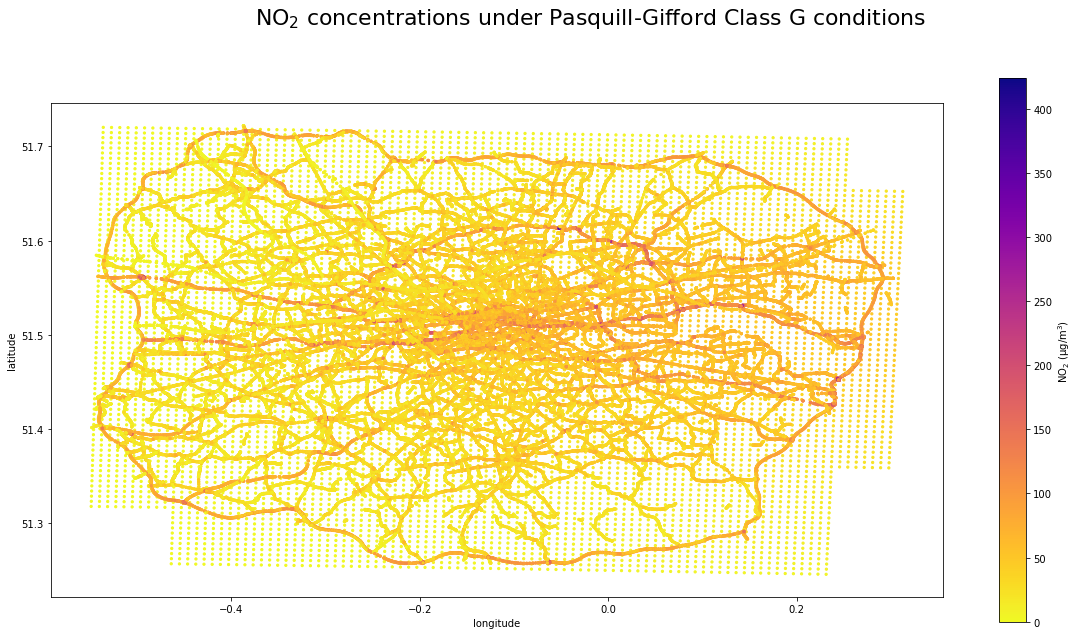

In [33]:
plot_in_grid_box(new_gdf, 
                 data_column, 
                 figsize=(20,10),
                 markersize=5, # 0.1 or more (depending on grid resolution)
                 title=f"NO$_2$ concentrations under Pasquill-Gifford Class {choose_PG_class} conditions", 
                 fontsize=22, 
                 colorbar_scale=None, # "log" or None
                 colorbar_label="NO$_2$ (μg/m$^3$)")

#### Re-gridding

So I'm currently using a dataset which is indexed by time and space i.e. my spatial dimension is a long list of coordinates indexed by longitude-latitude, rather than with longitude and latitude indexed separately so that the space is 2D.

Let's try gridding the data.

Adapted from [this tutorial](https://james-brennan.github.io/posts/fast_gridding_geopandas/).

In [156]:
xmin, ymin, xmax, ymax = new_gdf.total_bounds
n_cells = 146 # 150
cell_size = (xmax-xmin)/n_cells
grid_cells = [shapely.geometry.box(x0, y0, x0 - cell_size, y0 + cell_size) 
              for x0 in np.arange(xmin, xmax + cell_size, cell_size) 
              for y0 in np.arange(ymin, ymax + cell_size, cell_size)]

cell = gpd.GeoDataFrame(grid_cells, columns=["geometry"])

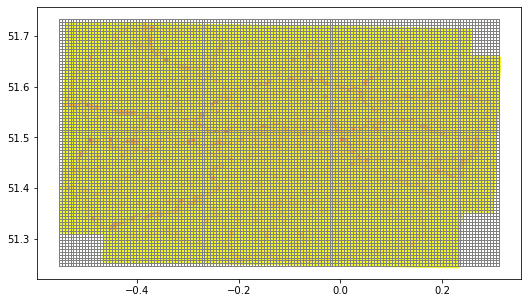

In [152]:
cell.plot(ax=new_gdf.plot(markersize=10, column=data_column, cmap="plasma_r", figsize=(10,5)), 
          facecolor="none", edgecolor="grey")
plt.show()

Merge the grid with the data points themselves:

In [157]:
merged_gdf = gpd.sjoin(new_gdf, cell, how="left", predicate="within")

Use the `.dissolve()` function to upsample the data to the grid:

In [158]:
dissolve = merged_gdf.dissolve(by="index_right", aggfunc="mean")
cell.loc[dissolve.index, data_column] = dissolve[data_column].values

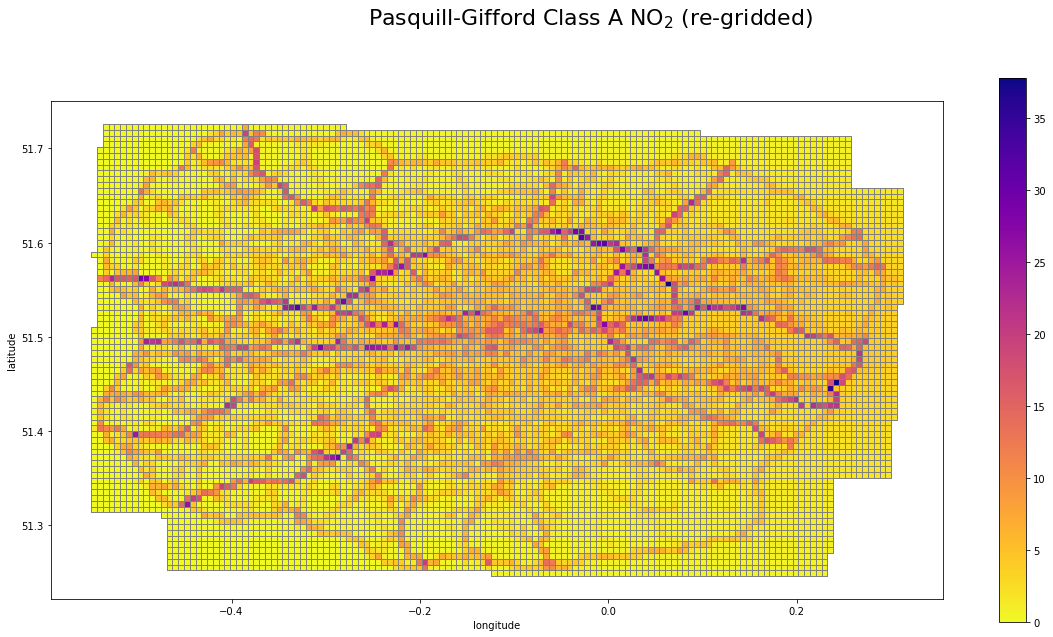

In [144]:
plot_in_grid_box(cell, 
                 data_column, 
                 figsize=(20,10), 
                 fontsize=22, 
                 title=f"Pasquill-Gifford Class {choose_PG_class} NO$_2$ (re-gridded)", 
                 edgecolor="grey")

In [116]:
plot_on_map(cell, london_boroughs_gdf, column=data_column, data_cmap="plasma_r", colorbar=True)

NameError: name 'london_boroughs_gdf' is not defined

This Pasquill-Gifford class data can be reshaped (what dimensions?) and made into an `xarray` dataset:

In [159]:
# What are the reshaping dimensions?
x_coords = cell.centroid.x.round(12).drop_duplicates()
y_coords = cell.centroid.y.round(12).drop_duplicates()
print(len(x_coords), len(y_coords), len(x_coords)*len(y_coords))
print(len(cell))

147 82 12054
12054


In [187]:
data_variables = {"NO2": (["longitude", "latitude"], cell[data_column].values.reshape(len(x_coords), len(y_coords)), new_ds.NO2.attrs)
                    }

coords = {"longitude": (["longitude"], x_coords),
            "latitude": (["latitude"], y_coords)}
     
attrs = new_ds.attrs

NO2_ds = xr.Dataset(data_vars=data_variables, coords=coords, attrs=attrs)

In [188]:
NO2_ds

<xarray.Dataset>
Dimensions:    (longitude: 151, latitude: 84)
Coordinates:
  * longitude  (longitude) float64 -0.5549 -0.5491 -0.5433 ... 0.304 0.3097
  * latitude   (latitude) float64 51.25 51.25 51.26 51.27 ... 51.72 51.72 51.73
Data variables:
    NO2        (longitude, latitude) float64 nan nan nan nan ... nan nan nan nan
Attributes: (12/14)
    File_Version:               2.0
    File_Type:                  Comprehensive output file
    Site_Name:                  Greater London
    Project_Name:               Preliminary 2019 with P-G classes
    Coordinate_System:          OSGB 1936 British National Grid (epsg:27700)
    EPSG:                       27700
    ...                         ...
    Model_Name:                 ADMS-Urban
    Model_Version:              5.0.0.1
    Model_Build_Number:         5129
    Model_Release_Date:         January 2020
    Date_Created:               9/12/2021
    Time_Created:               16:6:26

#### Pasquill-Gifford classes re-gridding

For the coordinate-processed `xarray` dataset, we need to re-grid each Pasquill-Gifford class and then reshape it...

I could loop through each P-G class and use `geopandas` to convert to a lat/lon grid, then stack the classes into a `numpy` array to then make into an `xarray` dataset:

Cycling through all the pollutant species:

In [105]:
# Specify pollutant variables to be gridded
variables = [var for var in list(new_ds.data_vars) if "wind" not in var]
variables

['NOx', 'NO2', 'PM10', 'PM2.5', 'CO2']

We need to exclude the wind variables because the data points are for the whole region and don't have a spatial distribution.

In [106]:
xmin, ymin, xmax, ymax = gpd.points_from_xy(new_ds.longitude.values, 
                                            new_ds.latitude.values).total_bounds

Test which n_cells parameter value will give us high re-gridding resolution with < 10% NaNs.

In [115]:
found_one = False
n_cells = None
ref_cell = None
x_coords = None
y_coords = None
NaN_pcent_threshold = 10
NaN_pcent_min = 100

for test_n_cells in tqdm(range(50, 1, -1)): #300
    cell_size = (xmax-xmin)/test_n_cells
    grid_cells = [shapely.geometry.box(x0, y0, x0 - cell_size, y0 + cell_size) 
              for x0 in np.arange(xmin, xmax + cell_size, cell_size) 
              for y0 in np.arange(ymin, ymax + cell_size, cell_size)]
    test_ref_cell = gpd.GeoDataFrame(grid_cells, columns=["geometry"])
    test_x_coords = test_ref_cell.centroid.x.round(12).drop_duplicates()
    test_y_coords = test_ref_cell.centroid.y.round(12).drop_duplicates()
    if len(test_ref_cell) == len(test_x_coords)*len(test_y_coords):
        variable = "NO2"
        i = 0
        # Grid the timeseries data
        cell_list = []
        cell = test_ref_cell.copy()
        class_gdf = gpd.GeoDataFrame(new_ds[variable][i, :].values, 
                         columns=[f"class_{variable}"], 
                         geometry=gpd.points_from_xy(new_ds.longitude.values, new_ds.latitude.values))
        merge = gpd.sjoin(class_gdf, test_ref_cell, how="left", predicate="within")
        dissolve = merge.dissolve(by="index_right", aggfunc="mean")
        cell.loc[dissolve.index, f"class_{variable}"] = dissolve[f"class_{variable}"].values
        cell_list.append(cell[f"class_{variable}"].values.reshape(len(test_x_coords),len(test_y_coords)))
        # Stack the grids into a numpy array
        classes_gridded = np.stack(cell_list, axis=-1)
        NaN_percentage = ((np.sum(np.isnan(classes_gridded)) / (classes_gridded.shape[0] * classes_gridded.shape[1] * classes_gridded.shape[2]))*100)
        if NaN_percentage <= NaN_pcent_threshold:
            found_one = True
            n_cells = test_n_cells
            ref_cell = test_ref_cell
            x_coords = test_x_coords
            y_coords = test_y_coords
            print(NaN_percentage.round(1))
            break
        elif NaN_percentage < NaN_pcent_min and not NaN_percentage <= NaN_pcent_threshold:
            NaN_pcent_min = NaN_percentage
            n_cells = test_n_cells
            ref_cell = test_ref_cell
            x_coords = test_x_coords
            y_coords = test_y_coords
if not found_one:
    print(f"Couldn't get data gaps below {NaN_pcent_threshold}%. Minimum achieved was {NaN_pcent_min.round(1)}%.")
print(n_cells)

100%|██████████| 49/49 [00:19<00:00,  2.50it/s]

Couldn't get data gaps below 10%. Minimum achieved was 10.3%.
40


In [97]:
grid_name = f"gridded_{n_cells}"

In [98]:
for variable in variables:
    print(variable)

    # Grid the timeseries data
    cell_list = []
    progress_bar = tqdm(range(0, new_ds.PG_class.shape[0]))

    for i in progress_bar:
        progress_bar.set_description(f"Gridding PG classes")
        cell = ref_cell.copy()
        class_gdf = gpd.GeoDataFrame(new_ds[variable][i, :].values, 
                         columns=[f"class_{variable}"], 
                         geometry=gpd.points_from_xy(new_ds.longitude.values, new_ds.latitude.values))
        merge = gpd.sjoin(class_gdf, ref_cell, how="left", predicate="within")
        dissolve = merge.dissolve(by="index_right", aggfunc="mean")
        cell.loc[dissolve.index, f"class_{variable}"] = dissolve[f"class_{variable}"].values
        cell_list.append(cell[f"class_{variable}"].values.reshape(len(x_coords),len(y_coords)))

    # Stack the grids into a numpy array
    classes_gridded = np.stack(cell_list, axis=-1)

    # Create the xarray dataset
    data_variables = {f"{variable}": (["longitude", "latitude", "PG_class"], classes_gridded, new_ds[variable].attrs)
                        }

    coords = {"longitude": (["longitude"], x_coords),
                "latitude": (["latitude"], y_coords),
             "PG_class": (["PG_class"], new_ds.PG_class.data)}

    attrs = new_ds.attrs

    classes_ds = xr.Dataset(data_vars=data_variables, coords=coords, attrs=attrs)

    # Save to a netCDF file
    if not path.exists(path.join(folder, grid_name)):
        makedirs(path.join(folder, grid_name))
    filepath = path.join(folder, grid_name, f"{variable}_PG_classes_grid.nc")
    classes_ds.to_netcdf(filepath)
    print(f"Saved to {filepath}.")

Gridding PG classes:   0%|          | 0/7 [00:00<?, ?it/s]

NOx


Gridding PG classes:   0%|          | 0/7 [00:00<?, ?it/s]

Saved to /home/users/mwlw3/ADMS-Urban/2018_P-G_classes/all_regions/003/gridded_297/NOx_PG_classes_grid.nc.
NO2


Gridding PG classes:   0%|          | 0/7 [00:05<?, ?it/s]


KeyboardInterrupt: 

### Comparing ADMS-Urban runs

In [34]:
def compute_metric(da, metric):
    if metric == "mean":
        return da.mean().values
    elif metric == "std":
        return da.std().values
    elif re.findall("q\d+", metric):
        return da.quantile(int(re.findall("\d+", metric)[0])/100).values

In [35]:
def plot_boxplots(runs, title, pollutant_choice="NO2", figsize=(20, 8), fontsize=15):
    metrics = ["mean", "std", "q0", "q25", "q50", "q75", "q100"]
    df = pd.DataFrame(columns=metrics)

    fig, axes = plt.subplots(nrows=1, ncols=len(runs), figsize=figsize, sharey=True)
    axes = axes.ravel()

    for run in runs:
        folder = f"/home/users/mwlw3/ADMS-Urban/2018_P-G_classes/all_regions/{run}/"
        griddings = [path.join(folder, item) for item in listdir(folder) if path.isdir(path.join(folder, item)) and item.split("_")[0]=="gridded"]
        filepath = path.join(folder, griddings[0], f"{pollutant_choice}_PG_classes_grid.nc")
        da = xr.open_dataset(filepath)[pollutant_choice]
        data_list = []
        for metric in metrics:
            data_list.append(compute_metric(da, metric))
        df = df.append(pd.DataFrame([data_list], columns=metrics, index=[run]))

        stats = [{
        "label": run,  # not required
        "med": df["q50"][run],
        "q1": df["q25"][run],
        "q3": df["q75"][run],
        "whislo": df["q0"][run],  # required
        "whishi": df["q100"][run],  # required
        "fliers": []  # required if showfliers=True
        }]

        axes[runs.index(run)].bxp(stats)
        if runs.index(run)==0:
            axes[runs.index(run)].set_ylabel(pollutant_choice, fontsize=fontsize)
        
    fig.suptitle(title, fontsize=fontsize)
    plt.show()

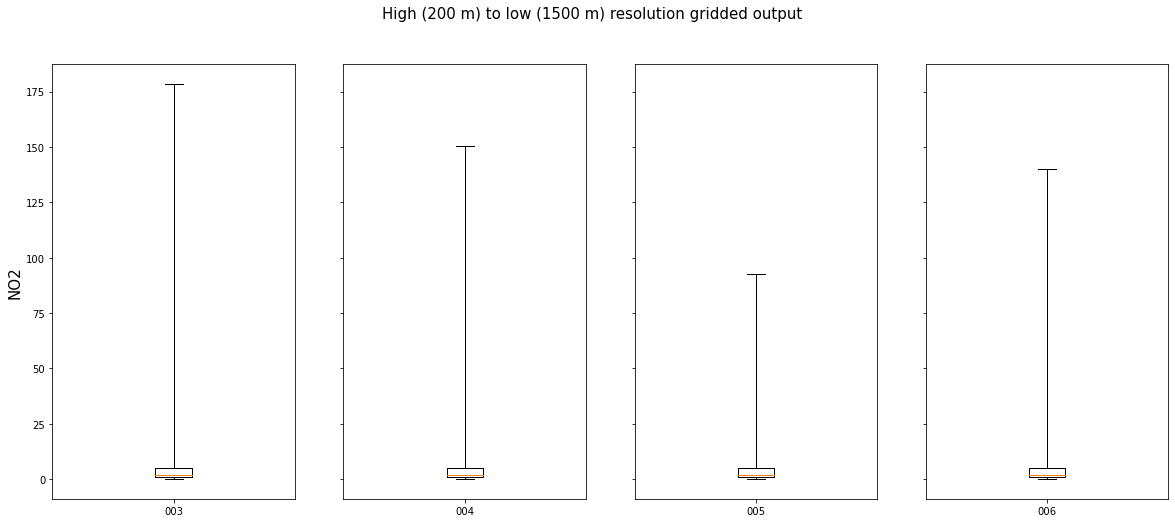

In [51]:
runs = ["003", "004", "005", "006"]
plot_boxplots(runs, "High (200 m) to low (1500 m) resolution gridded output")

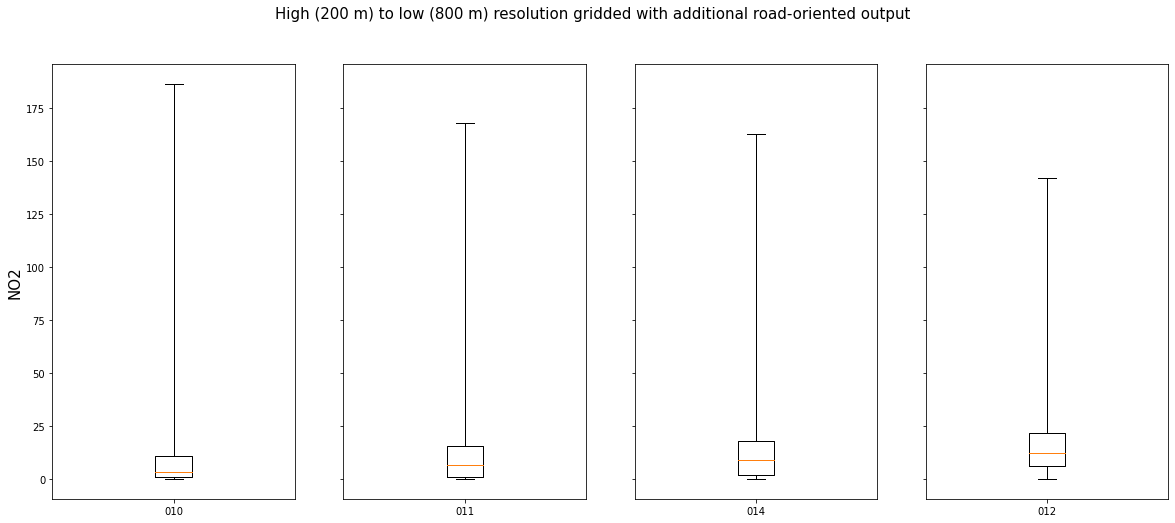

In [37]:
runs = ["010", "011", "014", "012"]
plot_boxplots(runs, "High (200 m) to low (800 m) resolution gridded with additional road-oriented output")

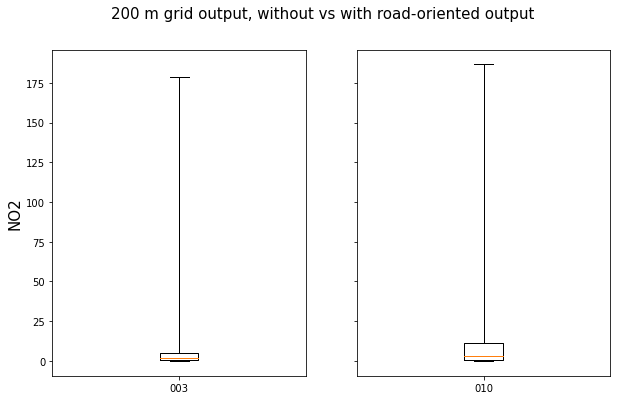

In [49]:
plot_boxplots(["003", "010"], "200 m grid output, without vs with road-oriented output", figsize=(10,6))

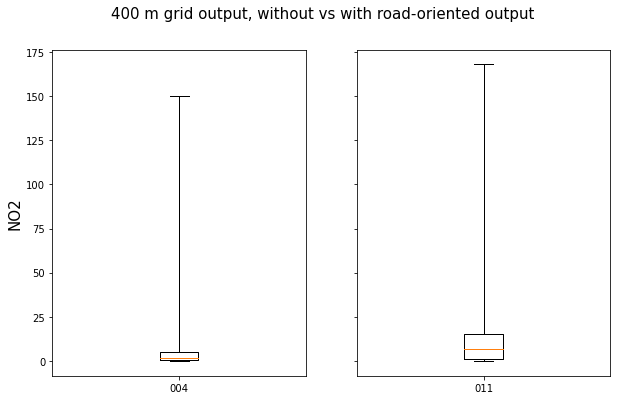

In [52]:
plot_boxplots(["004", "011"], "400 m grid output, without vs with road-oriented output", figsize=(10,6))

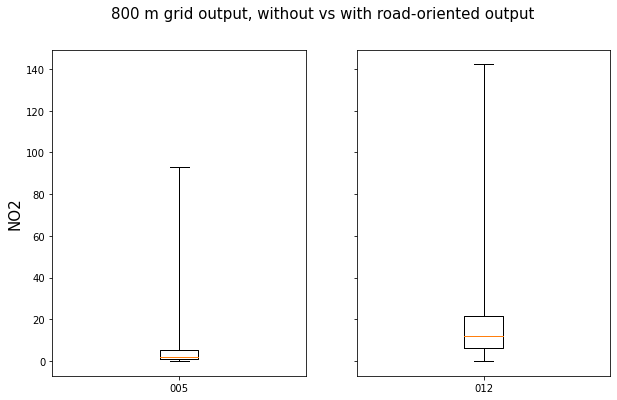

In [53]:
plot_boxplots(["005", "012"], "800 m grid output, without vs with road-oriented output", figsize=(10,6))

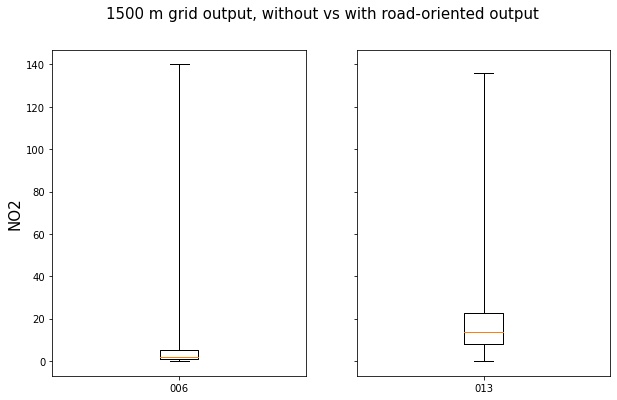

In [54]:
plot_boxplots(["006", "013"], "1500 m grid output, without vs with road-oriented output", figsize=(10,6))